In [265]:
#Importing the relevant libraries
import pickle
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense,Masking,LSTM,Input
from keras.callbacks import ModelCheckpoint

import os
from matplotlib import pyplot as plt

In [266]:
#Creating a text -> number dictionary and a number -> text dictionary
def create_dictionary(path):
    out_char_to_int = {}
    out_int_to_char = {}
    with open(path) as f:
        for line in f:
            for word in line.split():
                if word not in out_char_to_int:
                    out_char_to_int[word] = len(out_char_to_int)
                    out_int_to_char[len(out_int_to_char)] = word

    inp_char_to_int = out_char_to_int.copy()
    inp_int_to_char = out_int_to_char.copy()

    inp_char_to_int['x'] = len(inp_char_to_int)
    inp_int_to_char[len(inp_int_to_char)] = 'x'

    return [[inp_char_to_int, inp_int_to_char], [out_char_to_int, out_int_to_char]]


In [268]:
#Given a list of words remove all the punctuation and make them lower case
def clean_text(words):
    remove = [',',".","!","?","_",":",";",
    "(",")","[","]","{","}","'","\"","-","/",
    "\\","|","@","#","$","%","^","&","*","~",
    "`","=","+","<",">","0","1","2","3","4",
    "5","6","7","8","9"]
    for i in range(len(words)):
        words[i] = "".join(x for x in words[i] if x not in remove).lower()
    return words



        

In [269]:
#Given a list of words and a dictionary, convert the words to numbers
def text_to_int(words,dict_list):
    out = []
    for word in words:
        try:
            out.append(dict_list[0][0][word])
        except:
            out.append(dict_list[0][0]["x"])
    return out

In [271]:
#Generate training data
def create_training_data(words_as_number,char_to_int):
    #Create a list of all the possible sequence lengths
    seq_lengths = [1,2,3]

    #List to hold the training data
    dataX = []
    datay = []

    #Loop through all the possible sequence lengths
    for sequence_length in seq_lengths:
        #Loop through all the words in the text
        for i in range(len(words_as_number)-sequence_length):
            #Add the sequence to the training data
            dataX.append(words_as_number[i:i+sequence_length])
            out = words_as_number[i+sequence_length]
            #If the next word is an x, try to find a word that isn't an x
            if out == char_to_int["x"]:
                try:
                    buffer = 1
                    while out == char_to_int["x"]:
                        out = words_as_number[i+sequence_length+buffer]
                        buffer += 1
            #If there are no words that aren't x, try to find a word that isn't an x in the other direction
                except:
                    try:
                        buffer = 1
                        while out == char_to_int["x"]:
                            out = words_as_number[i+sequence_length+buffer]
                            buffer -= 1
            #If there are no words that aren't x in either direction, use the word "the"
                    except:
                        out = char_to_int["the"]
            datay.append(out)

    #Number of samples in the training data   
    num_samples = len(dataX)

    #Create a numpy array to hold the training data with the shape defined by the number of samples, the maximum sequence length and the number of features
    X = np.zeros((num_samples, max(seq_lengths), 1), dtype=np.float32)
    #Replace the 0s with the padding character
    X[X == 0.] = char_to_int["x"]
    
    #Loop through the training data and replace the padding character with the actual data 
    for i, x in enumerate(dataX):
        for j, c in enumerate(x):
            X[i, j, 0] = c

    
    # One-hot encode the output data
    y = np_utils.to_categorical(datay,num_classes=len(char_to_int)-1)

    return X,y




In [272]:
#Create the model
def create_model(output_list,inp_char_to_int):
    #Define the input shape
    inputs = Input(shape=(None, 1))
    #Replace the padding character with a mask
    mask = Masking(mask_value=inp_char_to_int['x'])(inputs)
    #Create the LSTM layers
    lstm = LSTM(32)(mask)
    #Create the dense layers
    dense = Dense(64, activation='relu')(lstm)
    dense2 = Dense(128, activation='relu')(dense)
    #Create the output layer
    outputs = Dense(len(output_list)-1, activation='softmax')(dense2)
    #Model creation
    model = Model(inputs, outputs)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

    return model

In [273]:
# Train the model
def train_model(model, X, y,ep):
    model.fit(X, y, epochs=ep, batch_size=32, verbose=2,validation_split=0.1)
    return model

In [275]:
   # summarize performance of the mode
def evaluate_model(model, X, y):
    scores = model.evaluate(X, y, verbose=0)
    print("Model Accuracy: %.2f%%" % (scores[1]*100))

In [276]:
path = r'C:\Users\silas\OneDrive\Skrivebord\AI\Text_data'

In [277]:
#Get text from a directory
def text_test(path,dict_list):
    words = []
    try:
        for file in os.listdir(path):
            with open(path+"\\"+file,"r") as f:
                for line in f:
                    for word in line.split():
                        words.append(word)
    except:
        for file in os.listdir(path):
            with open(path+"\\"+file,"r",encoding="utf8") as f:
                for line in f:
                    for word in line.split():
                        words.append(word)

    return text_to_int(clean_text(words),dict_list)

In [278]:
dict_list = create_dictionary(r"C:\Users\silas\OneDrive\Skrivebord\AI\test\dict2.txt")

char_to_int = dict_list[0][0]
output_list = dict_list[1][1]


model = create_model(output_list,char_to_int)

int_rep = text_test(path,dict_list)
X,y = create_training_data(int_rep,char_to_int)


history = train_model(model,X,y,100)

#Dump model
model.save("model2.h5")









    


Epoch 1/100
2215/2215 - 60s - loss: 6.1668 - accuracy: 0.0478 - val_loss: 6.3195 - val_accuracy: 0.0677 - 60s/epoch - 27ms/step
Epoch 2/100
2215/2215 - 47s - loss: 6.0478 - accuracy: 0.0489 - val_loss: 6.3012 - val_accuracy: 0.0677 - 47s/epoch - 21ms/step
Epoch 3/100
2215/2215 - 58s - loss: 6.0265 - accuracy: 0.0495 - val_loss: 6.2820 - val_accuracy: 0.0678 - 58s/epoch - 26ms/step
Epoch 4/100
2215/2215 - 60s - loss: 5.9826 - accuracy: 0.0499 - val_loss: 6.2373 - val_accuracy: 0.0646 - 60s/epoch - 27ms/step
Epoch 5/100
2215/2215 - 57s - loss: 5.9241 - accuracy: 0.0507 - val_loss: 6.1578 - val_accuracy: 0.0664 - 57s/epoch - 26ms/step
Epoch 6/100
2215/2215 - 50s - loss: 5.8890 - accuracy: 0.0515 - val_loss: 6.1317 - val_accuracy: 0.0649 - 50s/epoch - 23ms/step
Epoch 7/100
2215/2215 - 48s - loss: 5.8418 - accuracy: 0.0516 - val_loss: 6.1306 - val_accuracy: 0.0673 - 48s/epoch - 22ms/step
Epoch 8/100
2215/2215 - 46s - loss: 5.7988 - accuracy: 0.0519 - val_loss: 6.0555 - val_accuracy: 0.0662 

In [279]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


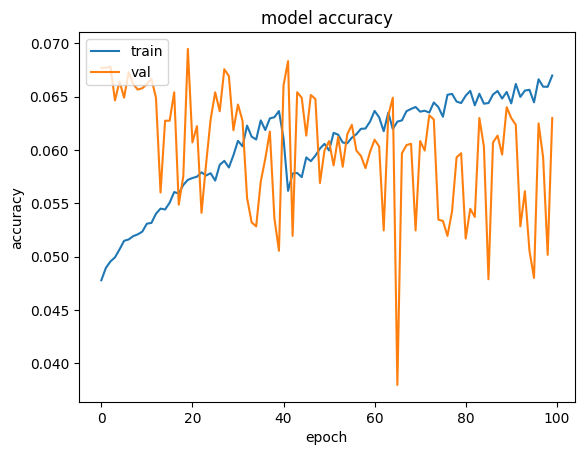

In [280]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [281]:
evaluate_model(model,X,y)


Model Accuracy: 6.91%


In [282]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

KeyError: 'loss'